# Simultaneous state and parameter estimation experiment

This `jupyter` notebook demonstrates a method for simultaneous state and parameter trajectory reconstruction for the classical Lotka-Volterra nonlinear dynamical system. It employs sparse Hessian based sequential quadratic programming (this repo!) under the hood. It also auto-generates required block Jacobian and Hessian `numpy` functions with the help of `sympy` (see `symfjh.py`). 

In [1]:
import numpy as np
import scipy.integrate as scintegr
import scipy.interpolate as scinterp
import sympy
import symfjh
import trapztr
import dampnewt
import matplotlib.pyplot as plt

#### Augmented state: stage vector

Define the dynamical system (Lotka Volterra ODE) in a generalized sense where all parameters augment the state variables. The original LV system is

$$\dot{x} = \alpha x - \beta x y \\ 
  \dot{y} = \delta x y - \gamma y$$ 
  
where states $x$, $y$, and parameters $\alpha \ldots \gamma$ are all positive. Let the stage vector $\mathbf{z}$ be defined as

$$\mathbf{z} = \left( x,y,\alpha,\beta,\gamma,\delta\right)$$

i.e. packing in all states and parameters. Assuming (a priori) that the parameters are constant in time the stage function $\mathbf{f}$ is defined as 

$$\mathbf{f}(\mathbf{z}) = \left(\begin{array}{c} z_2 z_0 - z_3 z_0 z_1 \\ z_5 z_0 z_1 - z_4 z_1 \\ 0 \\ 0 \\ 0 \\ 0 \end{array}\right)$$ 

and additionally the Jacobian $\nabla_{\mathbf{z}}\mathbf{f}$ and the Hessian $\nabla_{\mathbf{z}\mathbf{z}}^2\mathbf{f}$ are also required. In this notebook these are autogenerated with the help of `sympy.diff`.

In [2]:
x, y, a, b, c, d = sympy.symbols('x,y,a,b,c,d')

Z = [x, # prey
     y, # predator
     a, # alpha
     b, # beta
     c, # gamma
     d] # delta

F = [a * x - b * x * y, 
     d * x * y - c * y, 
     0, 
     0, 
     0, 
     0]

strF = symfjh.create_def_string('lvFunc', F, Z)
exec(strF)

J = symfjh.symJacobian(F, Z)
strJ = symfjh.create_def_string('lvGrad', J, Z)
exec(strJ)

H = symfjh.symHessianCube(F, Z)
strH = symfjh.create_def_string('lvHess', H, Z)
exec(strH)

nz = len(Z)

In [3]:
# Smoketest auto-generated numpy code
z = np.random.randn(nz)
assert lvFunc(z).shape == (nz,)
assert lvGrad(z).shape == (nz, nz)
assert lvHess(z).shape == (nz, nz, nz)

#### Main dynamical equation transcription method
All the stage vectors are linked by a (stochastic) trapezoidal transcription equation

$$\mathbf{z}_{k+1} = \mathbf{z}_{k} + \frac{h_k}{2}\left[ \mathbf{f}(\mathbf{z}_k) + \mathbf{f}(\mathbf{z}_{k+1}) \right] + \mathbf{w}_k$$ 

where the error term $\mathbf{w}$ which is taken as a realization of a normal random variate with zero mean and variance $h_k \boldsymbol{\sigma}^2$, where $h_k = t_{k+1} - t_{k}$. The dynamics part of the total optimization objective then reads

$$\frac{1}{2}\sum_k \sum_{j:\sigma_j > 0} \left(\frac{w_{k,j}}{\sigma_j}\right)^2$$ 

where $w_{k,j}$ is the $j$th element of the $k$th stage error $\mathbf{w}_k$. The above equation used together with discrete observations (below) will become the total optimization objective. Note that specific elements of the stage function $\mathbf{f}$ are "deactivated" from the cost objective by setting $\sigma_j \leq 0$.

But first generate the idealized test data from the LV ODE itself.

Integration successful.


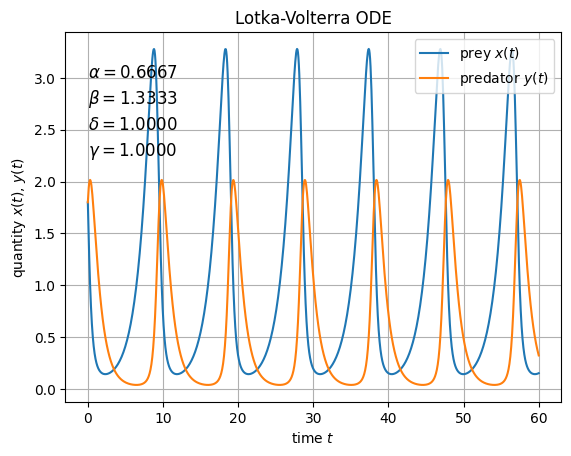

In [4]:
ode_lv_p = {'alpha' : 2.0 / 3.0, 
            'beta'  : 4.0 / 3.0,  
            'gamma' : 1.0,
            'delta' : 1.0, }

def ode_lv_func(y, t):
    assert y.size == 2
    z = np.array([y[0], y[1], ode_lv_p['alpha'], ode_lv_p['beta'], ode_lv_p['gamma'], ode_lv_p['delta']])
    zdot = lvFunc(z)
    return np.array([zdot[0], zdot[1]])

y0 = np.array([1.8, 1.8])
tvec = np.linspace(0.0, 60.0, 1001)
sol = scintegr.odeint(ode_lv_func, y0, tvec, full_output = 1)

assert sol[0].shape[0] == tvec.size and sol[0].shape[1] == y0.size 
print(sol[1]['message'])

plt.plot(tvec, sol[0][:, 0], label = 'prey $x(t)$')
plt.plot(tvec, sol[0][:, 1], label = 'predator $y(t)$')
plt.grid(True)
plt.xlabel('time $t$')
plt.ylabel('quantity $x(t)$, $y(t)$')
plt.title('Lotka-Volterra ODE')
plt.text(0.0, 3.00, r'$\alpha={:.4f}$'.format(ode_lv_p['alpha']), fontsize = 12)
plt.text(0.0, 2.75, r'$\beta={:.4f}$'.format(ode_lv_p['beta']), fontsize = 12)
plt.text(0.0, 2.50, r'$\delta={:.4f}$'.format(ode_lv_p['delta']), fontsize = 12)
plt.text(0.0, 2.25, r'$\gamma={:.4f}$'.format(ode_lv_p['gamma']), fontsize = 12)
plt.legend(loc = 'upper right')
plt.show()

#### Generate randomly located mildly noisy observations

Each one introduces a quadratic cost term 

$$\frac{1}{2}\left(\frac{z_{t,i} - b_{t,i}}{\sigma_{t,i}}\right)^2$$

at a specific time $t$ for a specific stage variable $i$. Here only $x$ and $y$ gets to be observed. The parameters are completely hidden.

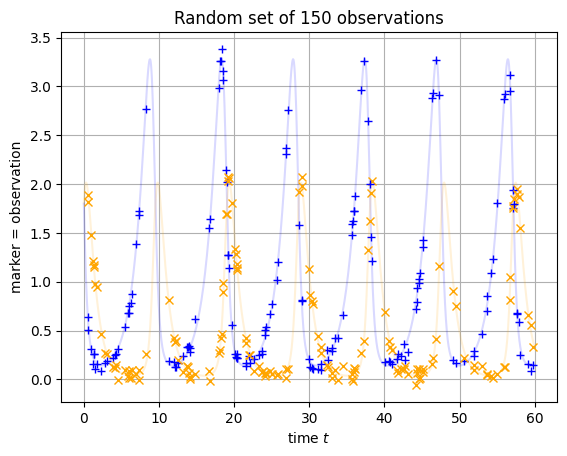

In [5]:
npts = int(500)
tpts = np.linspace(tvec[0], tvec[-1], npts)
sgma = np.ones((nz, )) * 0.10
wgth = np.zeros((nz, ))

num_obsv = 150
sigma_obsv = 0.05
ptCost = {}
for i in range(num_obsv):
    time_obsv = tvec[0] + np.random.rand() * (tvec[-1] - tvec[0])
    x_at_time = scinterp.interp1d(tvec, sol[0][:, 0])(time_obsv)
    x_err = np.random.randn() * sigma_obsv
    y_at_time = scinterp.interp1d(tvec, sol[0][:, 1])(time_obsv)
    y_err = np.random.randn() * sigma_obsv
    ptCost['obsv{}'.format(i)]  = { 'time'  : time_obsv, 
                                    'type'  : int(2),
                                    'bias'  : np.array([x_at_time + x_err, 
                                                        y_at_time + y_err, 
                                                        np.nan, 
                                                        np.nan, 
                                                        np.nan, 
                                                        np.nan]), 
                                    'sigma' : sigma_obsv * np.array([1.0, 
                                                                     1.0, 
                                                                     -1.0, 
                                                                     -1.0, 
                                                                     -1.0, 
                                                                     -1.0]) }
assert len(ptCost) == num_obsv

plt.plot(tvec, sol[0][:, 0], color = 'blue', alpha = 0.15)
plt.plot(tvec, sol[0][:, 1], color = 'orange', alpha = 0.15)
for i in range(len(ptCost)):
    cost_term = ptCost['obsv{}'.format(i)]
    plt.plot(cost_term['time'], cost_term['bias'][0], marker = '+', color = 'blue')
    plt.plot(cost_term['time'], cost_term['bias'][1], marker = 'x', color = 'orange')

plt.grid(True)
plt.xlabel('time $t$')
plt.ylabel('marker = observation')
plt.title('Random set of {} observations'.format(len(ptCost)))
plt.show()

In [6]:
# transcription objective function returning sparse hessian using the stage function triad {f, jac, hess}
def obj(a):
    a, ga, ha = trapztr.totalObjective(a, lvFunc, lvGrad, lvHess, tpts, sgma, wgth, None, ptCost)
    return a, ga, ha

print('--- trust-ellipsoid plain-vanilla Newton ({} variables) ---'.format(npts * nz))

X0 = np.random.randn(npts * nz) * 0.10 + np.ones((npts * nz, ))

dntres = dampnewt.solve(obj, x0 = X0, lmbda0 = 1.0, verbosity=0)

if dntres['converged']:
    print('{} iterations'.format(dntres['iters']))
else:
    print('damped newton did not converge')


--- trust-ellipsoid plain-vanilla Newton (3000 variables) ---
26 iterations


dict_keys(['iters', 'converged', 'sparse', 'niqs', 'usedsqp', 'x', 'fx', 'infg'])


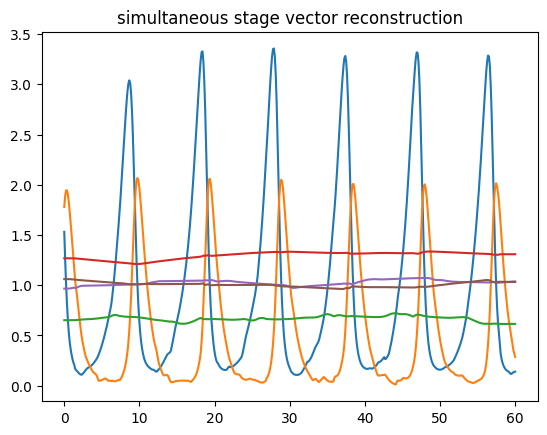

In [7]:
print(dntres.keys())

if dntres['converged']:
    # Make a plot of the solution and also report time-averaged error bars
    Zopt = dntres['x'].reshape((npts, nz))

    plt.plot(tpts, Zopt)
    plt.title('simultaneous stage vector reconstruction')
    plt.show()

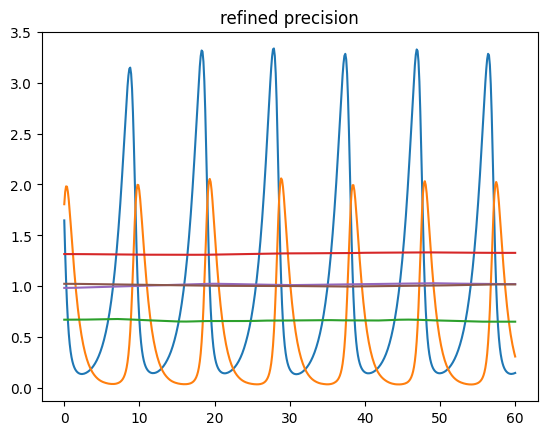

In [8]:
assert dntres['converged']

# Refine the "precision" of the simultaneous reconstruction by a factor of 10x
sgma_shrunk = np.copy(sgma) / 10.0

def refined_obj(a):
    a, ga, ha = trapztr.totalObjective(a, lvFunc, lvGrad, lvHess, tpts, sgma_shrunk, wgth, None, ptCost)
    return a, ga, ha

refined_sol = dampnewt.solve(refined_obj, x0 = dntres['x'], lmbda0 = 1.0e-2, verbosity = 0)
assert refined_sol['converged']

Zref = refined_sol['x'].reshape((npts, nz))
plt.plot(tpts, Zref)
plt.title('refined precision')
plt.show()

(3000, 3000)
[0.02135816 0.01715514 0.01616674 0.0260978  0.02268412 0.02333156]


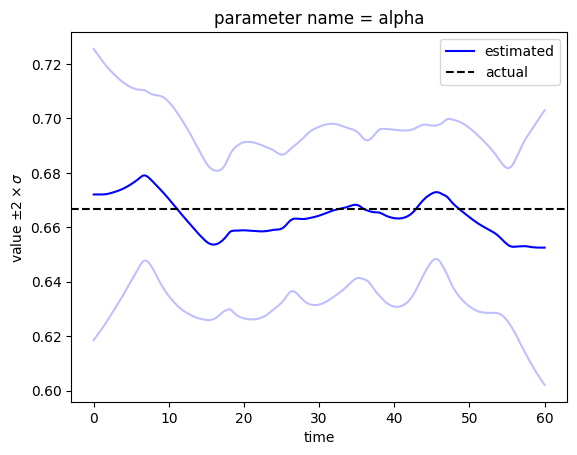

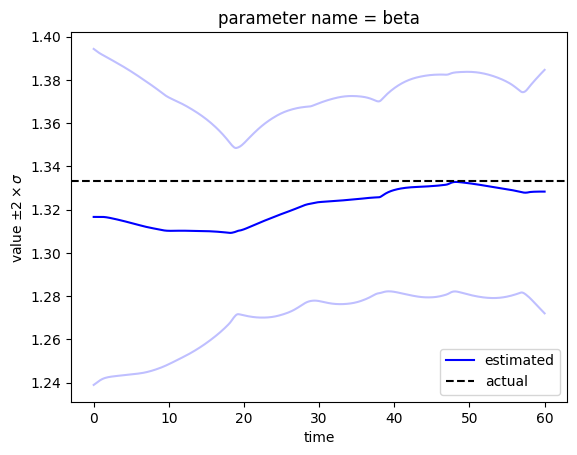

In [9]:
# Report time-averaged "error bars" for the parameters based on the Hessian value at the refined solution
_, _, Href = refined_obj(refined_sol['x'])

print(Href.shape)
Zref_sd = trapztr.sqrt_of_diag_of_inv_hess(Href).reshape((npts, nz))
print(np.mean(Zref_sd, axis = 0))

znames = ['x', 'y', 'alpha', 'beta', 'gamma', 'delta']

# Produce illustration of estimated parameter trajectories
for k in range(len(znames)):
    if not (k == 2 or k == 3): continue
    plt.plot(tpts, Zref[:, k], alpha = 1.0, c = 'b', label = 'estimated')
    plt.plot(tpts, Zref[:, k] - 2 * Zref_sd[:, k], alpha = 0.25, c = 'b')
    plt.plot(tpts, Zref[:, k] + 2 * Zref_sd[:, k], alpha = 0.25, c = 'b')
    plt.axhline(y = ode_lv_p[znames[k]], c = 'k', linestyle = '--', label = 'actual')
    plt.title('parameter name = {}'.format(znames[k]))
    plt.xlabel('time')
    plt.ylabel('value $\pm 2\\times\\sigma$')
    plt.legend()
    plt.show()

### Useful reference

This calculation was inspired by the methods employed in this paper: <https://doi.org/10.1103/PhysRevE.92.052901>.